In [1]:
from utils import *

In [2]:
df = pd.read_csv("data_W2023.csv")


In [3]:
df.head()

,date,shareprice
0,01-Jan-1973,1.168677
1,01-Feb-1973,1.166112
2,01-Mar-1973,1.258816
3,01-Apr-1973,1.260858
4,01-May-1973,1.288661


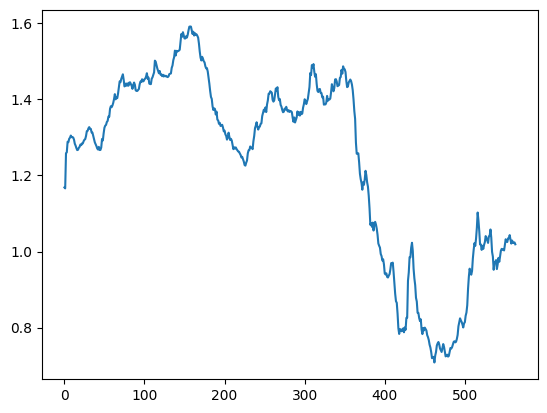

In [4]:
plt.plot(df["shareprice"])

In [5]:
df = df[df["date"] < "2019-12-01"]

In [6]:
df.shape

(564, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564 entries, 0 to 563
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        564 non-null    object 
 1   shareprice  564 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.2+ KB


In [8]:
df["date"] = pd.to_datetime(df["date"])